## promptmanteau
port·man·teau is a word blending the sounds and combining the meanings of two others, for example motel (from ‘motor’ and ‘hotel’) or brunch (from ‘breakfast’ and ‘lunch’).

Mechanistic Intepretability project <br>
for [Apart Research #4 Hackathon](https://itch.io/jam/mechint) by [Mentaleap](https://mentaleap.ai/)


## Installation

In [1]:
!pip install numpy
!pip install matplotlib
!pip install torch
!pip install tqdm
!pip install datasets
!pip install transformers

DEPRECATION: --no-binary currently disables reading from the cache of locally built wheels. In the future --no-binary will not influence the wheel cache. pip 23.1 will enforce this behaviour change. A possible replacement is to use the --no-cache-dir option. You can use the flag --use-feature=no-binary-enable-wheel-cache to test the upcoming behaviour. Discussion can be found at https://github.com/pypa/pip/issues/11453
DEPRECATION: --no-binary currently disables reading from the cache of locally built wheels. In the future --no-binary will not influence the wheel cache. pip 23.1 will enforce this behaviour change. A possible replacement is to use the --no-cache-dir option. You can use the flag --use-feature=no-binary-enable-wheel-cache to test the upcoming behaviour. Discussion can be found at https://github.com/pypa/pip/issues/11453
DEPRECATION: --no-binary currently disables reading from the cache of locally built wheels. In the future --no-binary will not influence the wheel cache. 

## Imports

In [2]:
from copy import deepcopy
from pathlib import Path
from dataclasses import dataclass
import re
import itertools
    
import numpy as np
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import ExponentialLR

from transformers import GPT2LMHeadModel, GPT2TokenizerFast, LogitsProcessor, LogitsProcessorList, LogitsWarper
from datasets import load_dataset


/Users/itay/.pyenv/versions/3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Lib

In [3]:
class SoftEmbedding(nn.Module):
    def __init__(self, 
                wte: nn.Embedding,
                n_tokens: int = 10, 
                random_range: float = 0.5,
                initialize_from_vocab: bool = True):
        super(SoftEmbedding, self).__init__()
        self.wte = wte
        self.n_tokens = n_tokens
        self.learned_embedding = nn.parameter.Parameter(self.initialize_embedding(wte,
                                                                               n_tokens, 
                                                                               random_range, 
                                                                               initialize_from_vocab))
    def initialize_embedding(self, 
                             wte: nn.Embedding,
                             n_tokens: int = 10, 
                             random_range: float = 0, 
                             initialize_from_vocab: bool = True):
        """initializes learned embedding

        Args:
            same as __init__

        Returns:
            torch.float: initialized using original schemes
        """
        if initialize_from_vocab:
            return self.wte.weight[:n_tokens].clone().detach()
            
        return torch.FloatTensor(n_tokens, wte.weight.size(1)).uniform_(-random_range, random_range)
            
    def forward(self, tokens):
        """run forward pass

        Args:
            tokens (torch.long): input tokens before encoding

        Returns:
            torch.float: encoding of text concatenated with learned task specifc embedding
        """
        input_embedding = self.wte(tokens[:, self.n_tokens:])
        learned_embedding = self.learned_embedding.repeat(input_embedding.size(0), 1, 1)
        return torch.cat([learned_embedding, input_embedding], 1)

## Init Model

In [4]:
# Loading gpt2 model
model_name = "gpt2"
tokenizer = GPT2TokenizerFast.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

In [5]:
# Freezing the model
for p in model.parameters():
    p.requires_grad = False

In [6]:
# overriding model embedding layer
n_tokens = 1
initialize_from_vocab = False

current_embedding = deepcopy(model.get_input_embeddings())
s_wte = SoftEmbedding(current_embedding, n_tokens=n_tokens, initialize_from_vocab=initialize_from_vocab)

model.set_input_embeddings(s_wte)
params_before_training = deepcopy(s_wte.learned_embedding)

In [7]:
def run_model(model, tokenizer, query):
    inputs = tokenizer(query, return_tensors="pt")
    
    end_of_text_padding = torch.full((1, n_tokens), 50256)
    inputs['input_ids'] = torch.cat([end_of_text_padding, inputs['input_ids']],  dim=1)
    ones = torch.full((1, n_tokens), 1)
    inputs['attention_mask'] = torch.cat([ones, inputs['attention_mask']], dim=1)
    
    return model(**inputs).logits[:, -1]

## Task Definition / Data Loading

In [8]:
# Our dataset is comprised of the numbers 0-500.
# Our task is +1
# Each of these numbers is encoded with a single token (useful for task simplicity) 
# We sample 100 numbers from this range and fit the task-token to correspond for +1.
# label_ids a dict:
    # matches query (number in range 0-500) with answer (the number+1).
# identity_label_ids:
    # # matches query (number in range 0-500) with answer (the same number).
    
dataset = np.random.randint(500, size=(100,))
evalset  = list(range(500))

plus_two_task = {i: tokenizer.encode(str(i+2))[0] for i in range(500)}
plus_one_task = {i: tokenizer.encode(str(i+1))[0] for i in range(500)}
identity_task = {i: tokenizer.encode(str(i))[0] for i in range(500)}

format_query = lambda x: f"{x},"

def only_relevant_logits(logits, task_mapping):
    '''
        task_mapping: maps between inputs to f(inputs)
        returns list of predictions with indices corresponding to the INPUT, and values corresponding to the OUTPUT
        meaning that the prediction[x] = probablity(f(x))
    '''
    possible_outcomes = list(task_mapping.values())
    return logits[:,possible_outcomes] # looks only on relevant answers. index for answer is actually according to the query

task = identity_task

## Prompt-Tuning (Task) Training

In [9]:
optimizer = AdamW([model.transformer.wte.learned_embedding], lr=1e-3)
scheduler = ExponentialLR(optimizer, gamma=0.9)
n_epochs = 10
loss_f = nn.CrossEntropyLoss()

In [10]:
# Training loop
total_loss = []
for epoch in range(n_epochs):
    epoch_loss = 0
    for query in tqdm(dataset):
        # formatted_query, formatted_answer = format_query(query), torch.LongTensor([query])
        formatted_query, formatted_answer = format_query(query), torch.LongTensor([task[query]])
        
        optimizer.zero_grad()
        # preds = only_relevant_logits(run_model(formatted_query), task).reshape(1, -1)
        preds = run_model(model, tokenizer, formatted_query).reshape(1, -1)
        loss = loss_f(preds, formatted_answer)
        
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
    scheduler.step()
    print("Epoch Loss:", epoch_loss)
    total_loss.append(epoch_loss)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 11.04it/s]


Epoch Loss: 548.6201276779175


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.83it/s]


Epoch Loss: 273.1594034433365


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.21it/s]


Epoch Loss: 159.80558349192142


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.50it/s]


Epoch Loss: 84.80769973248243


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.36it/s]


Epoch Loss: 49.02762904390693


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.46it/s]


Epoch Loss: 32.34241774119437


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.18it/s]


Epoch Loss: 23.49921423010528


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.13it/s]


Epoch Loss: 18.250906142406166


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.01it/s]


Epoch Loss: 14.847236903384328


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.81it/s]

Epoch Loss: 12.488434534985572


## Prompt-Tuning Eval

In [11]:
corrects = 0
for query in tqdm(evalset):
    # preds = only_relevant_logits(run_model(format_query(query)), task).reshape(1, -1)
    preds = run_model(model, tokenizer, format_query(query)).reshape(1, -1)
    # corrects += int(query == torch.argmax(preds))
    f = int(task[query] == torch.argmax(preds))
    corrects += f
    
print(f"Task Accuracy: {100*corrects / len(evalset):.2f}%")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:13<00:00, 37.95it/s]

Task Accuracy: 99.60%


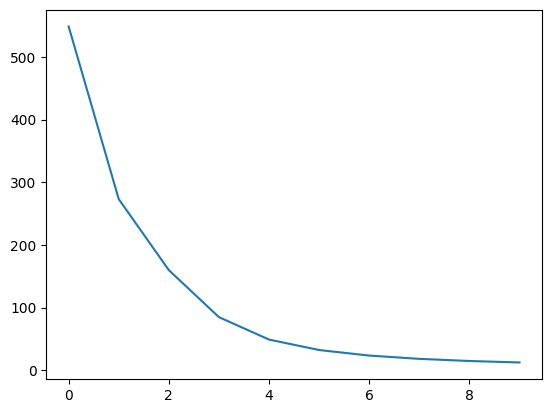

In [12]:
plt.plot(total_loss)

## Store Task Token

In [13]:
dir_ = Path("promptmanteau_tokens")
dir_.mkdir(parents=True, exist_ok=True)

In [14]:
task_token_path = dir_ / "identity_token3.pth"
torch.save(model.get_input_embeddings().learned_embedding, task_token_path)

## Analysis of Task-Tokens

In [15]:
token01 = torch.load(dir_ / "identity_token1.pth").detach()
token02 = torch.load(dir_ / "identity_token2.pth").detach()

token11 = torch.load(dir_ / "add1_token1.pth").detach()
token12 = torch.load(dir_ / "add1_token2.pth").detach()
token13 = torch.load(dir_ / "add1_token3.pth").detach()
token14 = torch.load(dir_ / "add1_token4.pth").detach()

token21 = torch.load(dir_ / "add2_token1.pth").detach()
token22 = torch.load(dir_ / "add2_token2.pth").detach()
token23 = torch.load(dir_ / "add2_token3.pth").detach()

tokens = [token01, token02]

In [16]:
def generate_random_coeffs_for_convex_sum(n):
    nums = np.random.rand(n)
    return nums / sum(nums)

In [17]:
for i, j in itertools.combinations(range(len(tokens)), 2):
    first_token = tokens[i]
    second_token = tokens[j]
    cos_sim = F.cosine_similarity(first_token, second_token).item()
    print(f"cosine similiarity <{i},{j}> = {cos_sim:.4f}")

cosine similiarity <0,1> = 0.0889


In [18]:
def generate_text(modified_model, tokenizer, query, n_tokens, **kwargs):
    padding = "<|endoftext|>" * n_tokens 
    text_to_encode = padding + query
    encoding = tokenizer.encode(text_to_encode, return_tensors="pt")
    result = modified_model.generate(encoding, **kwargs)[0]
    result = result[n_tokens:]
    decoded_result = tokenizer.decode(result)
    
    return [decoded_result]

In [19]:
def modify_model(model, task_tokens):
    assert hasattr(model.get_input_embeddings(), "learned_embedding"), "Model had to be constructed using SoftEmbedding class"
    model2 = deepcopy(model)
    model2.get_input_embeddings().learned_embedding = nn.Parameter(torch.cat(task_tokens).detach())
    return model2

In [20]:
prompts = ["122,",
           "36,",
          "7,",
          "1,",
          "2,",
          "13,",]

for i in range(1):
    coeffs = generate_random_coeffs_for_convex_sum(len(tokens))
    coeffs = [1,1]
    print("coeffs_list:", coeffs)
    convex_comb_token = torch.tensor(coeffs).float() @ torch.cat(tokens) # some hacks for the case of list of size 1
    task_tokens = [convex_comb_token] # we only have one token in this analysis
    for prompt in prompts:
        
        print(f"\tinput: {prompt}")  
        model2 = modify_model(model, task_tokens)
        decoded = generate_text(model2, tokenizer, prompt, n_tokens=len(task_tokens), max_new_tokens=2, pad_token_id=tokenizer.eos_token_id)
        for output in decoded:
            print(f"\tgenerate: {repr(output)}")

        print("-" * 80)  

coeffs_list: [1, 1]
	input: 122,
	generate: '122,11.'
--------------------------------------------------------------------------------
	input: 36,
	generate: '36,null.'
--------------------------------------------------------------------------------
	input: 7,
	generate: '7,7.'
--------------------------------------------------------------------------------
	input: 1,
	generate: '1,{.'
--------------------------------------------------------------------------------
	input: 2,
	generate: '2,2.'
--------------------------------------------------------------------------------
	input: 13,
	generate: '13,11.'
--------------------------------------------------------------------------------


### evaluation of the convex sum TASK

In [21]:
corrects = 0

tokens = [token01, token02]
coeffs = generate_random_coeffs_for_convex_sum(len(tokens))

convex_comb_token = torch.tensor(coeffs).float() @ torch.cat(tokens)
task_tokens = [convex_comb_token]

model2 = modify_model(model, task_tokens)
for query in tqdm(evalset):
    # preds = only_relevant_logits(run_model(format_query(query)), task).reshape(1, -1)
    preds = run_model(model2, tokenizer, format_query(query)).reshape(1, -1)
    # corrects += int(query == torch.argmax(preds))
    f = int(task[query] == torch.argmax(preds))
    corrects += f
    
print(f"Task Accuracy: {100*corrects / len(evalset):.2f}%")
print(coeffs)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:13<00:00, 38.32it/s]

Task Accuracy: 94.00%
[0.66746926 0.33253074]
